In [15]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os
import threading
import sys

from six.moves import xrange
import scipy.io as sio
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf


# configuration
BATCH_SIZE = 19
NUM_SUBPLOT_COLS = 10
DATASET_PATH = "./data/train.mat"
VALID_DATASET_PATH = "./data/test_32x32.mat"
GEN_TEST_PATH = "./data/test_images.mat"
# 10 - '0', 1000 lines
GEN_LABELS_PATH = "labels.txt"

CROP_RATE = 0.75
CROP_H = int(32 * CROP_RATE)
CROP_W = int(32 * CROP_RATE)

NUM_CLASSES = 10
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN = 168 # 73257
NUM_EXAMPLES_PER_EPOCH_FOR_EVAL = 100
NUM_EXAMPLES_PER_EPOCH_FOR_TEST = 100

class DataLoader:
  def __init__(self, data_path, batch_size=50, num_valid_samples=None, is_test=False):
    if is_test:
      assert num_valid_samples == NUM_EXAMPLES_PER_EPOCH_FOR_TEST, "num_valid_samples must be %d under TEST mode" % NUM_EXAMPLES_PER_EPOCH_FOR_TEST
      print("TEST mode")
    self.is_test = is_test
    print("loading raw file:", data_path)
    data = sio.loadmat(data_path)
    self.images = data['X']
    self.images = np.transpose(self.images, (3, 0, 1, 2))
    if not is_test:
      self.labels = data['y']
      self.labels[self.labels==10] = 0
    self.num_valid_samples = num_valid_samples
    self.batch_size = num_valid_samples or batch_size
    if (not is_test) and (self.num_valid_samples != None):
      self.random_valid_set()
    # create queue
    print("filling input queue")
    self.queue_image = tf.placeholder(tf.int32, shape=[self.batch_size, 32, 32, 3], name="input_images")
    if not is_test:
      self.queue_label = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name="input_labels")
    if self.num_valid_samples == None:
      capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size
    else:
      capacity=int(self.num_valid_samples * 0.4) + 3 * self.batch_size
    if not is_test:
      dtypes = [tf.int32, tf.int32]
      shapes = [[32, 32, 3], [1]]
      to_enqueue = [self.queue_image, self.queue_label]
    else:
      dtypes = [tf.int32]
      shapes = [[32, 32, 3]]
      to_enqueue = [self.queue_image]
    self.example_queue = tf.FIFOQueue(
      capacity=capacity,
      dtypes=dtypes,
      shapes=shapes)
    self.enqueue = self.example_queue.enqueue_many(to_enqueue)
    self.enqueue_thread = None
    self.coord = tf.train.Coordinator()
    self.threads = None

  def random_valid_set(self):
    num_valid_samples = self.num_valid_samples
    dataset_size = self.images.shape[0]
    start = np.random.randint(0, dataset_size - num_valid_samples)
    self.images = self.images[start:start+num_valid_samples]
    self.labels = self.labels[start:start+num_valid_samples]
    print("random validation set [%d:%d]" % (start, start+num_valid_samples))
    gen_test_dict = {'X':self.images}
    sio.savemat(GEN_TEST_PATH, gen_test_dict)
    print("generated", GEN_TEST_PATH)
    
  def data_stream(self, session):
    try:
      start = 0
      dataset_size = len(self.images)
      while not self.coord.should_stop():
        end = start + self.batch_size
        # print("loading [%d:%d] into input queue..." % (start, end))
        if end <= dataset_size:
          image_batch = self.images[start:end]
          if not self.is_test:
            label_batch = self.labels[start:end]
          start = end
        else:
          remaining = end - dataset_size
          image_batch = np.concatenate((self.images[start:dataset_size], self.images[0:remaining]))
          if not self.is_test:
            label_batch = np.concatenate((self.labels[start:dataset_size], self.labels[0:remaining]))
          start = remaining
        if not self.is_test:
          session.run(
            self.enqueue, 
            feed_dict={
              self.queue_image : image_batch,
              self.queue_label : label_batch})
        else:
          session.run(self.enqueue, feed_dict={self.queue_image: image_batch})
      print("data stream closed.")
    except:
      print("data stream canceled.")
      sys.exit()

  def preprocess(self):
    if not self.is_test:
      image, label = self.example_queue.dequeue()
      image = tf.cast(image, tf.float32)
      label = tf.cast(label, tf.int32)
    else:
      image= self.example_queue.dequeue()
      image = tf.cast(image, tf.float32)
    if self.num_valid_samples == None:
      image = tf.random_crop(image, [CROP_H, CROP_W, 3])
      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_brightness(image, max_delta=63)
      image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    else:
      image = tf.image.resize_image_with_crop_or_pad(image, CROP_H, CROP_W)
    float_image = tf.image.per_image_standardization(image)
    if not self.is_test:
      return float_image, label
    else:
      return float_image

  def load_batch(self):
    if not self.is_test:
      image, label= self.preprocess()
      label.set_shape([1])
    else:
      image = self.preprocess()
    image.set_shape([int(32 * CROP_RATE), int(32 * CROP_RATE), 3])
    if self.num_valid_samples == None:
      image_batch, label_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=self.batch_size,
        num_threads=4,
        capacity=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4) + 3 * self.batch_size,
        min_after_dequeue=int(NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN * 0.4))
    else:
      if not self.is_test:
        image_batch, label_batch = tf.train.batch(
          [image, label],
          batch_size=self.batch_size,
          num_threads=4,
          capacity=int(self.num_valid_samples * 0.4) + 3 * self.batch_size)
      else:
        image_batch = tf.train.batch(
          [image],
          batch_size=self.batch_size,
          num_threads=4,
          capacity=int(self.num_valid_samples * 0.4) + 3 * self.batch_size)
    print("loading batch of samples:", self.batch_size) 
    if not self.is_test:
      return image_batch, tf.reshape(label_batch, [self.batch_size])
    else:
      return image_batch

  def load(self, session):
    self.enqueue_thread = threading.Thread(target=self.data_stream, args=[session])
    self.enqueue_thread.isDaemon()
    self.enqueue_thread.start()
    self.threads = tf.train.start_queue_runners(coord=self.coord, sess=session)
    
  def close(self, session):
    session.run(self.example_queue.close(cancel_pending_enqueues=True))
    self.coord.request_stop()
    self.coord.join(self.threads)
    print("dataloader closed successfully.")


loading raw file: ./data/test_32x32.mat
random validation set [22151:22251]
generated ./data/test_images.mat
filling input queue
loading batch of samples: 100
(100, 24, 24, 3) (100,)
data stream canceled.
dataloader closed successfully.


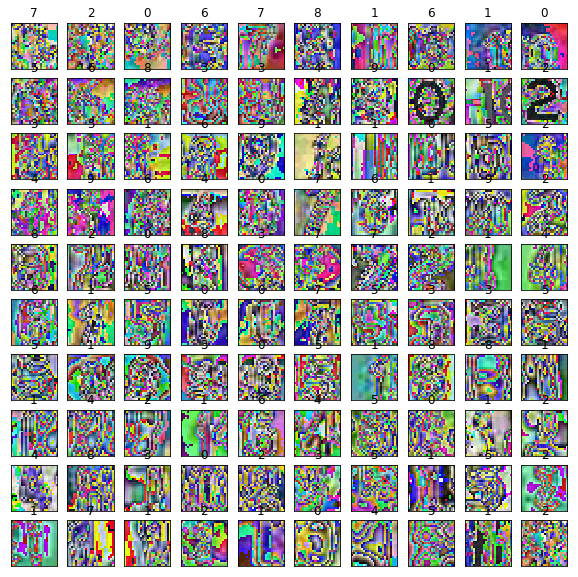

In [2]:
if __name__ == "__main__":
  fig = plt.figure(figsize=(10, 10))
  num_valid_samples = NUM_EXAMPLES_PER_EPOCH_FOR_EVAL
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(num_valid_samples/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(VALID_DATASET_PATH, num_valid_samples=num_valid_samples)
    image_batch, label_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      dataloader.load(session)
      images, labels = session.run([image_batch, label_batch], options=run_options)
      print(images.shape, labels.shape)
      for batch_i in range(num_valid_samples):
        sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
        sub_plot.title.set_text("%d" % labels[batch_i])
        sub_plot.xaxis.set_visible(False)
        sub_plot.yaxis.set_visible(False)
        plt.imshow(images[batch_i])
      dataloader.close(session)
  plt.show()


loading raw file: ./data/train_32x32.mat
filling input queue
loading batch of samples: 19
(19, 24, 24, 3) (19,)


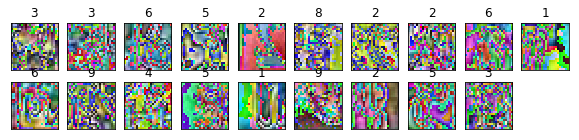

(19, 24, 24, 3) (19,)


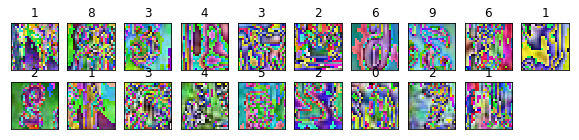

(19, 24, 24, 3) (19,)


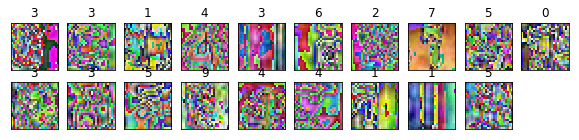

(19, 24, 24, 3) (19,)


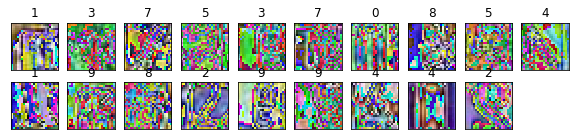

(19, 24, 24, 3) (19,)


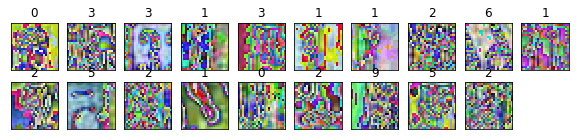

(19, 24, 24, 3) (19,)


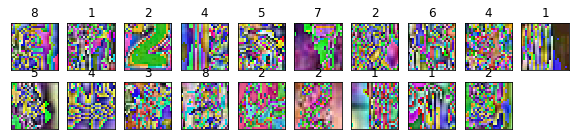

(19, 24, 24, 3) (19,)


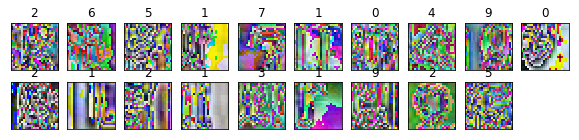

(19, 24, 24, 3) (19,)


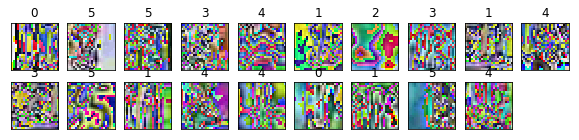

(19, 24, 24, 3) (19,)


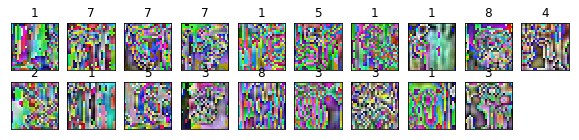

(19, 24, 24, 3) (19,)


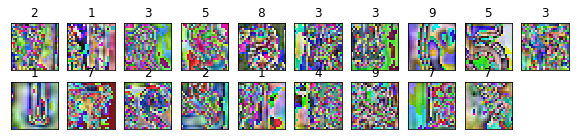

data stream canceled.
dataloader closed successfully.


In [11]:
if __name__ == "__main__":
  num_valid_samples = BATCH_SIZE
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(num_valid_samples/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(DATASET_PATH, BATCH_SIZE)
    image_batch, label_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      dataloader.load(session)
      for i in range(10):
        fig = plt.figure(figsize=(10, 2))
        images, labels = session.run([image_batch, label_batch], options=run_options)
        print(images.shape, labels.shape)
        # for row in range(num_plot_rows):
        #  print(labels[row*num_plot_cols:(row+1)*num_plot_cols])
        for batch_i in range(num_valid_samples):
          sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
          sub_plot.title.set_text("%d" % labels[batch_i])
          sub_plot.xaxis.set_visible(False)
          sub_plot.yaxis.set_visible(False)
          plt.imshow(images[batch_i])
        plt.show()
      dataloader.close(session)


In [ ]:
if __name__ == "__main__":
  fig = plt.figure(figsize=(10, 10))
  num_valid_samples = NUM_EXAMPLES_PER_EPOCH_FOR_TEST
  num_plot_cols = NUM_SUBPLOT_COLS
  num_plot_rows = int(math.ceil(num_valid_samples/num_plot_cols))
  labels = []

  with tf.Graph().as_default():
    dataloader = DataLoader(GEN_TEST_PATH, num_valid_samples=num_valid_samples, is_test=True)
    image_batch = dataloader.load_batch()
    run_options = tf.RunOptions(timeout_in_ms=4000000)
    with tf.Session() as session:
      dataloader.load(session)
      images = session.run([image_batch], options=run_options)
      print(images.shape)
      for batch_i in range(num_valid_samples):
        sub_plot = fig.add_subplot(num_plot_rows, num_plot_cols, batch_i+1)
        sub_plot.xaxis.set_visible(False)
        sub_plot.yaxis.set_visible(False)
        plt.imshow(images[batch_i])
      dataloader.close(session)
  plt.show()


TEST mode
loading raw file: ./data/test_images.mat
filling input queue
loading batch of samples: 100
data stream canceled.
